<font size="10">Apply *TopicVelo* to scNT-seq (a metabolic labeling method) human haematopoiesis</font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.io import mmwrite 
from scipy.sparse import csr_matrix, hstack

import tomotopy as tp
from tomotopy.coherence import Coherence
from tomotopy.utils import Corpus

import scvelo as scv
from scvelo.utils import get_transition_matrix

In [2]:
from topicvelo.tm_utils import cells_to_documents, fast_topics_cluster_assign, topic_genes_filter, remove_u, topic_genes_qc, aggregate_clusters
from topicvelo.embed_pl import plot_topics, plot_top_topic_genes, plot_genes, plot_velocity, mfpt_plot, comparision_stacked_bar_plot, comparision_violin_plot_v2, relative_flux_plot 
from topicvelo.dist_pl import plot_exper_jd, plot_burst_sim_jd, plot_os_analytical_jd, heatmap_exper_cluster_focus_jd
from topicvelo.transcription_simulation import geometric_burst_transcription, joint_distribution_analysis, joint_distribution_analysis_exper
from topicvelo.inference_tools import burst_inference_gene, KL_divergence, topic_threshold_heuristic_plot, Burst_Inference
from topicvelo.transition_matrix import combined_topics_transitions, get_cells_indices, velocity_graph
from topicvelo.vel_eval_utils import *

<font size="6">read the data which was provided in the *dynamo* paper</font>

In [3]:
#download data at https://uchicago.box.com/s/6ars8qijvt2axbjhxcriu9hybu3gkhkg
adata = scv.read('data/scNT-seq/hsc_hv2000.h5ad')
adata.var_names_make_unique
adata.var.index = adata.var['gene_name'].tolist()

<font size="10">Preprocessing</font>
<br>
<font size="6">We create a matrix ```S_U``` by stacking the spliced and unspliced count matrix and save this matrix and the assoicated gene names</font>

In [4]:
genes_S = adata.var['gene_name'].to_list()
genes_U = [g+'_U' for g in genes_S]
gene_names = np.hstack((genes_S, genes_U))

In [5]:
S_U = csr_matrix(hstack([adata.layers['raw_spliced'], adata.layers['raw_unspliced']]), dtype=np.int32)
mmwrite('data/scNT-seq/scNT_HH_filtered_SU_Counts', S_U)
pd.DataFrame(gene_names).to_csv("data/scNT-seq/scNT_HH_filtered_SU_Genes_names.csv")
pd.DataFrame(adata.obs_names.to_list()).to_csv("data/scNT-seq/scNT_HH_filtered_SU_Cells_names.csv")

<font size="10">Analysis with scVelo</font>
<br>
<font size="6">We use the stochastic model to compute the velocity and the associated transition matrix.</font>

In [6]:
scv.tl.velocity(adata, vkey='scvelo_stochastic_velocity')
scv.tl.velocity(adata, vkey='scvelo_stochastic_velocity')
scv.tl.velocity_graph(adata, vkey='scvelo_stochastic_velocity')

computing velocities
    finished (0:00:00) --> added 
    'scvelo_stochastic_velocity', velocity vectors for each individual cell (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'scvelo_stochastic_velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/1947 [00:00<?, ?cells/s]

    finished (0:00:01) --> added 
    'scvelo_stochastic_velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'scvelo_stochastic_velocity_umap_ori', embedded velocity vectors (adata.obsm)


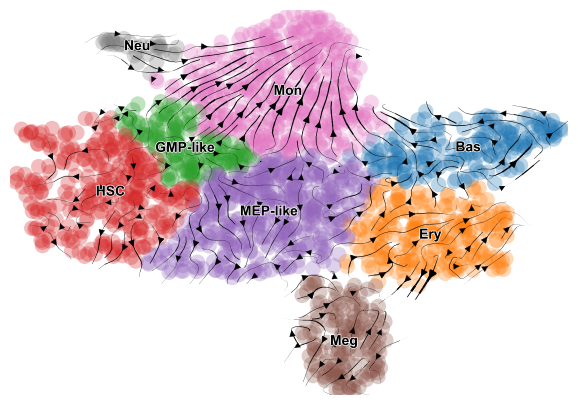

In [7]:
scv.pl.velocity_embedding_stream(adata, basis='umap_ori',dpi=100, 
                                 color='cell_type', vkey='scvelo_stochastic_velocity', legend_loc='on data', title = '', figsize=(7.2, 5))

<font size="10">Identify optimal number of topics with Tomotopy</font>
<br>
<font size="6">We run topic modeling over a range of topic numbers for 100 reptitions each then compute a coherence measures $c_V$ to determine a reasonable range for the number of topics</font>

In [8]:
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
reps = 50

In [9]:
lda_models = np.zeros((len(ks), reps), dtype=object)
coherence_cv = np.zeros((len(ks), reps))

In [10]:
corpus = Corpus()
for i in range(adata.n_obs):
    corpus.add_doc(cells_to_documents(S_U[i,:].A[0], gene_names))

In [11]:
for k in range(len(ks)): 
    for r in range(reps):
        #perform topic modeling for a variety of topic numbers
        lda = tp.LDAModel(k=ks[k], rm_top=0)
        lda.burn_in = 50
        lda.add_corpus(corpus)
        #may want to change the parallel parameters
        lda.train(iter=150, parallel=4)
        lda_models[k][r] =  lda
        coherence_cv[k,r] = Coherence(lda, coherence='c_v').get_score()

Text(0.5, 0, 'Number of Topics')

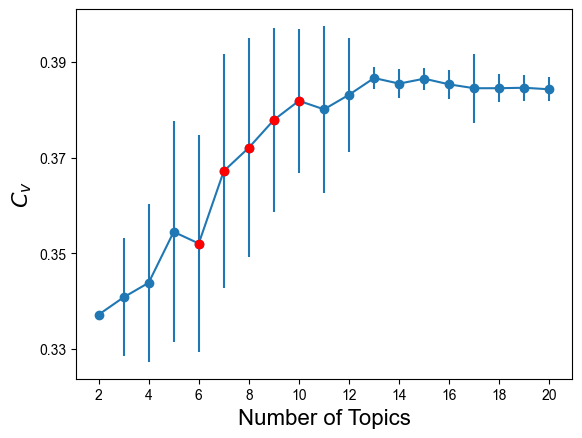

In [12]:
coherence_means = np.mean(coherence_cv, axis=1)
coherence_err = np.std(coherence_cv, axis=1)
plt.errorbar(ks, coherence_means,  yerr=coherence_err, fmt='o-',zorder=1)
plt.scatter([6,7,8,9,10], coherence_means[4:9],c='red', zorder=2)
plt.ylabel('$C_v$', size=16)
plt.xticks([2,4,6,8,10,12,14,16,18,20])
plt.yticks([0.33, 0.35, 0.37, 0.39])
plt.xlabel('Number of Topics', size=16)

<font size="6">From the result above we notice for more than 8 topics, the mean of $C_v$ across 100 reptitions stablizes around 0.4. We do not want to overfit the model so we chose K=8 for further analysis. </font>
<br>
<font size="6">Now we perform topic modeling in *R* using *FastTopics* which can perform advanced differential expression analysis. Please see the *R* markdown file. </font>


<font size="6">After we finished runing the *R* Markodown file, the topic weights and differential expression analysis are saved locally. We load the topic weights of cells and add the topic weights to the adata object. Then we visulize the topic weights on umap.</font>

In [13]:
#load the cellweights from fast topics and skip header and first column which are just junk
cellWeights = np.genfromtxt('data/scNT-seq/scNT_HH_fastTopics_fit_CellWeights.csv', delimiter=",", skip_header=1)[:,1:]

In [14]:
#get topic number
K = cellWeights.shape[1]
print(cellWeights.shape)

(1947, 8)


In [15]:
#add topic weights
fast_topics_cluster_assign(adata, cellWeights, t_type = 'fastTopics')

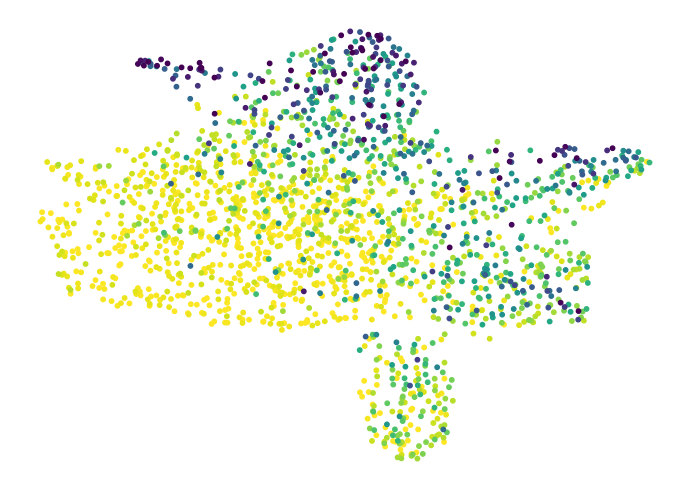

<Figure size 640x480 with 0 Axes>

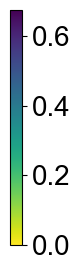

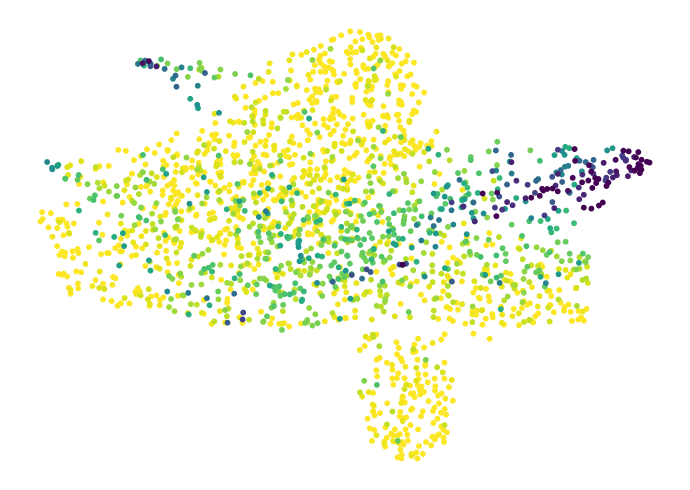

<Figure size 640x480 with 0 Axes>

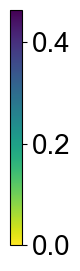

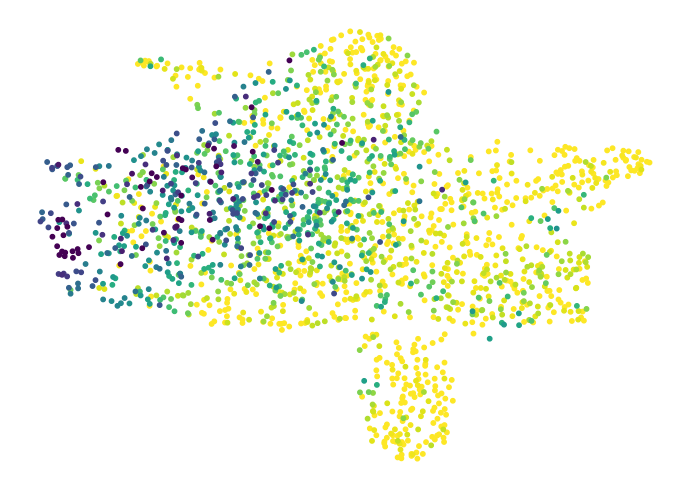

<Figure size 640x480 with 0 Axes>

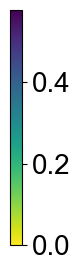

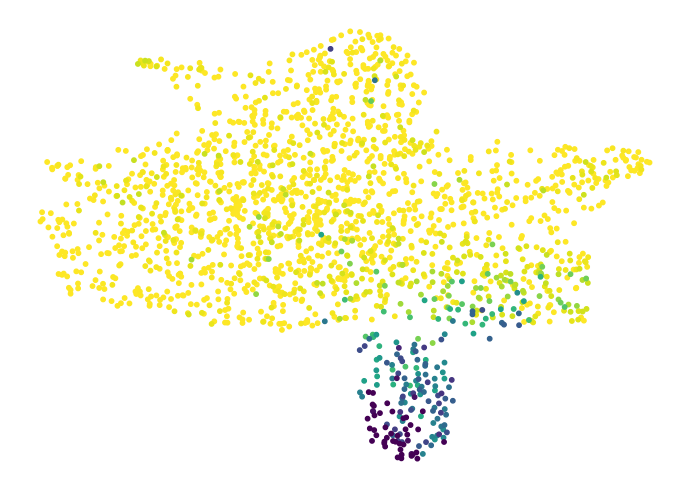

<Figure size 640x480 with 0 Axes>

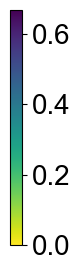

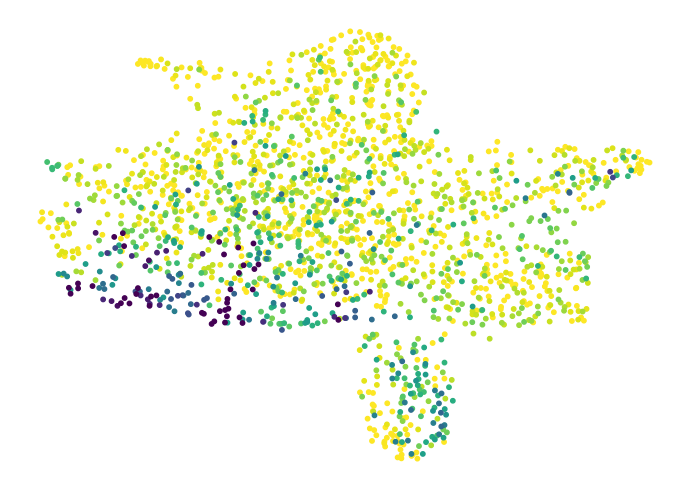

<Figure size 640x480 with 0 Axes>

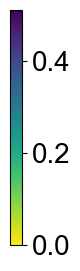

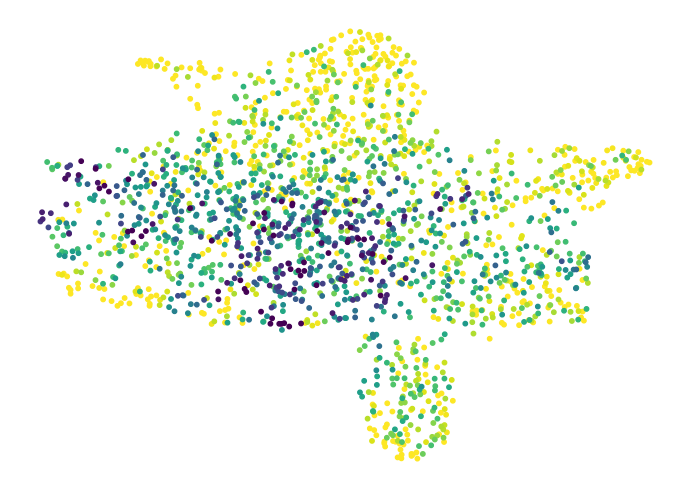

<Figure size 640x480 with 0 Axes>

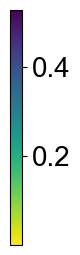

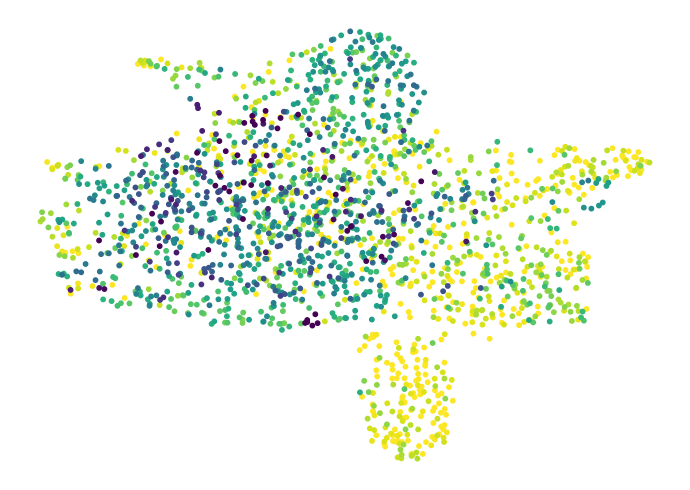

<Figure size 640x480 with 0 Axes>

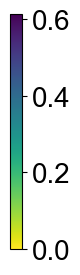

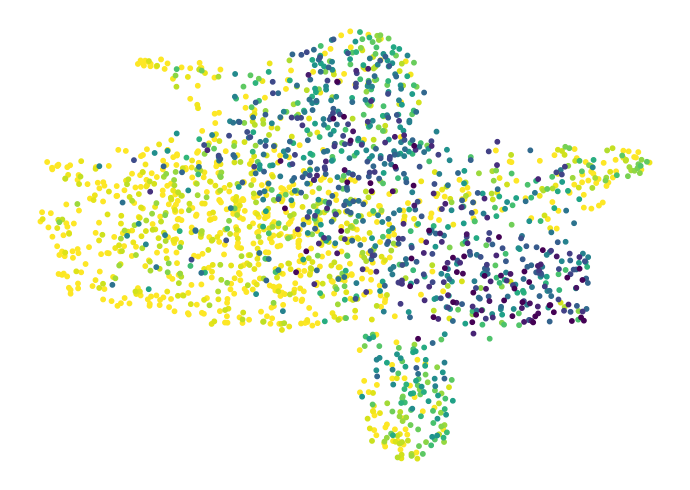

<Figure size 640x480 with 0 Axes>

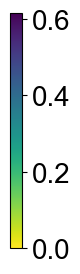

In [16]:
#plot the topics
for i in range(K):
    plot_topics(adata, str(i), t_type = 'fastTopics', basis='umap_ori', savefile = True, point_size=10, shrink=0.5, 
                labelsize=20, cbar_save='topic'+str(i)+'weights.svg')

<font size="6">load the differential expression analysis from *FastTopics*. Select topic genes then add them to the adata object for later access</font>

In [17]:
#load the cellweights from fast topics and skip header and first column which are just junk
de_postmean = np.genfromtxt('data/scNT-seq/scNT_HH_de_postmean.csv', delimiter=",", skip_header=1)[:,1:]
de_lfsr = np.genfromtxt('data/scNT-seq/scNT_HH_de_lfsr.csv', delimiter=",", skip_header=1)[:,1:]
de_z = np.genfromtxt('data/scNT-seq/scNT_HH_de_z.csv', delimiter=",", skip_header=1)[:,1:]

In [18]:
#select the topic genes
ttgs, ttg_up, ttg_down = topic_genes_filter(de_postmean, de_lfsr, 
                                            lfc_up_th = 0.5, lfc_down_th=-0.5, 
                                            lfsr_up_th = 0.001, lfsr_down_th = 0.001)

In [19]:
top_genes = remove_u(ttgs, gene_names)
top_genes_up = remove_u(ttg_up, gene_names)
top_genes_down = remove_u(ttg_down, gene_names)

#show how many topic genes have a positive log-fold changes in each topic
for ttgs_up_k in top_genes_up:
    print(len(ttgs_up_k))
print('\n')
for ttgs_k in top_genes:
    print(len(ttgs_k))

78
37
24
92
54
18
30
20


78
43
32
94
57
20
33
26


In [20]:
adata.uns['top_genes'] = top_genes

<font size="6">Let's make a few bar plots to look at genes with the highest log-fold changes in topics 1, 3, 5, 6</font>

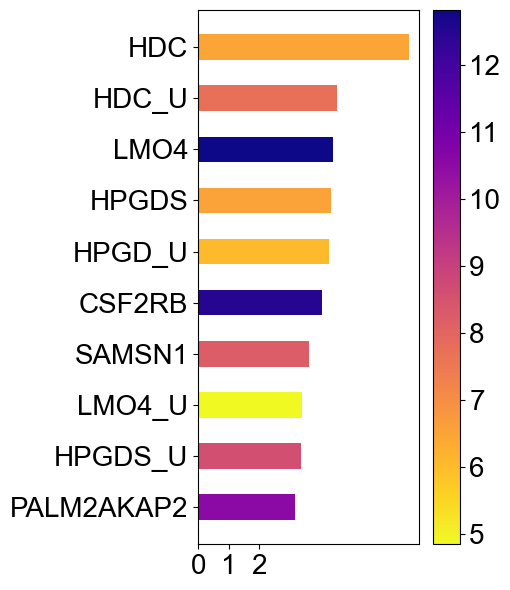

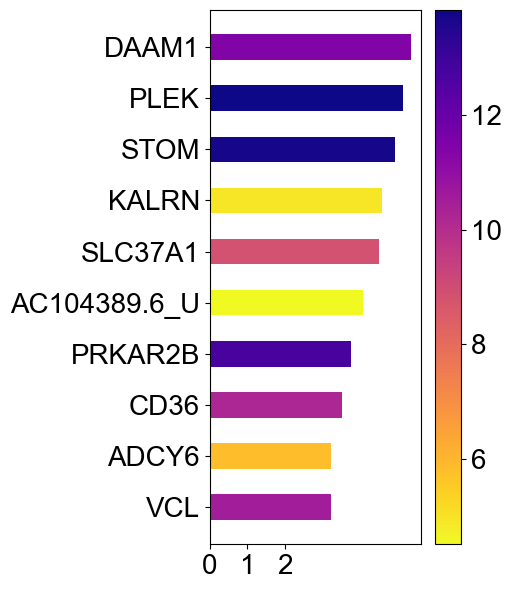

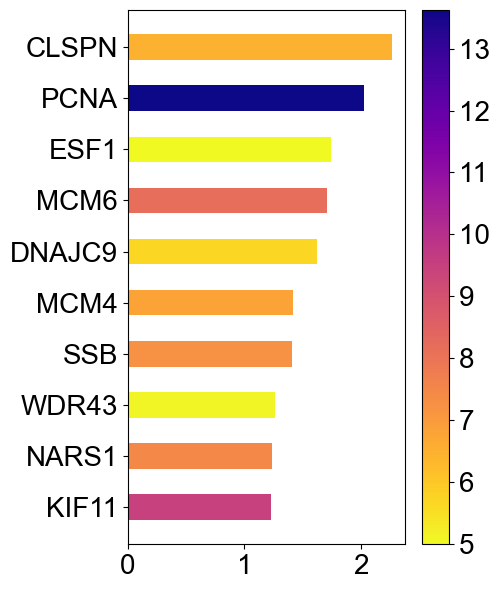

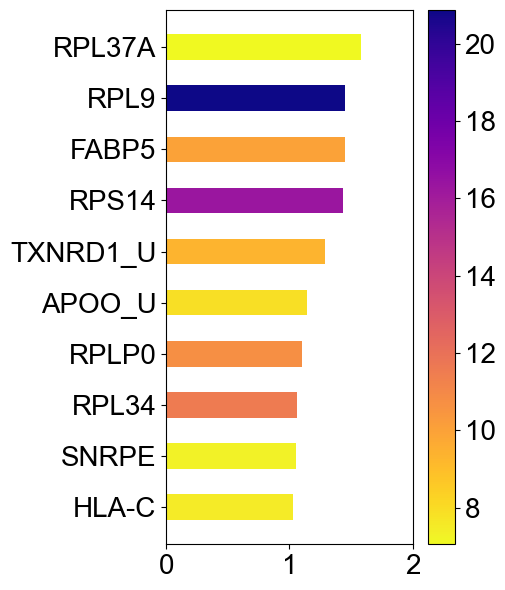

In [21]:
ttg_names1, log_fold_change_ttg1, z_ttg1 = plot_top_topic_genes(10, 1, gene_names, ttg_up, de_postmean, de_z,  save='scNT_HH_k=8_t1_up_ttg.svg', xticks=[0, 1, 2], figsize=(5,6))    
ttg_names3, log_fold_change_ttg3, z_ttg3  = plot_top_topic_genes(10, 3, gene_names, ttg_up, de_postmean, de_z, save='scNT_HH_k=8_t3_up_ttg.svg', xticks=[0, 1, 2], figsize=(5,6))
ttg_names5, log_fold_change_ttg5, z_ttg5  = plot_top_topic_genes(10, 5, gene_names, ttg_up, de_postmean, de_z, save='scNT_HH_k=8_t5_up_ttg.svg', xticks=[0, 1, 2], figsize=(5,6))    
ttg_names6, log_fold_change_ttg6, z_ttg6 = plot_top_topic_genes(10, 6, gene_names, ttg_up, de_postmean, de_z, save='scNT_HH_k=8_t6_up_ttg.svg', xticks=[0, 1, 2], figsize=(5,6))    

<font size="6">Plot some examples expression of topic genes. We will plot the size-normalized expression on the log-scale in the following order</font>
<br>
<font size="6">For topic 1 we plot *HDC*</font>
<br>
<font size="6">For topic 3 we plot *PLEK*</font>
<br>
<font size="6">For topic 5 we plot *PCNA*</font>
<br>
<font size="6">For topic 6 we plot *RPL9*</font>

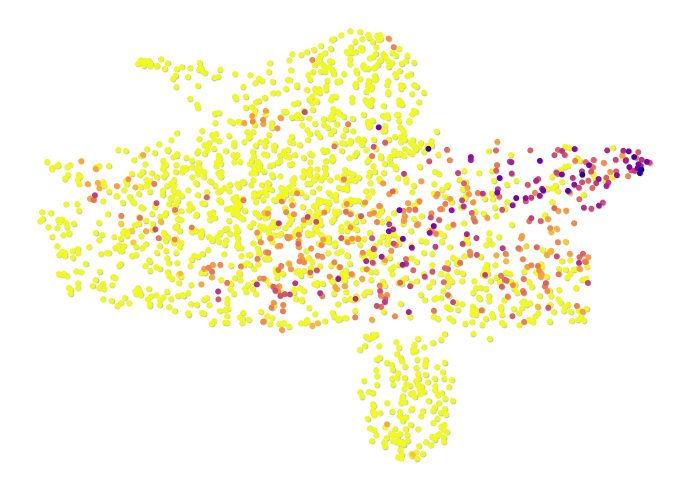

<Figure size 640x480 with 0 Axes>

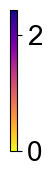

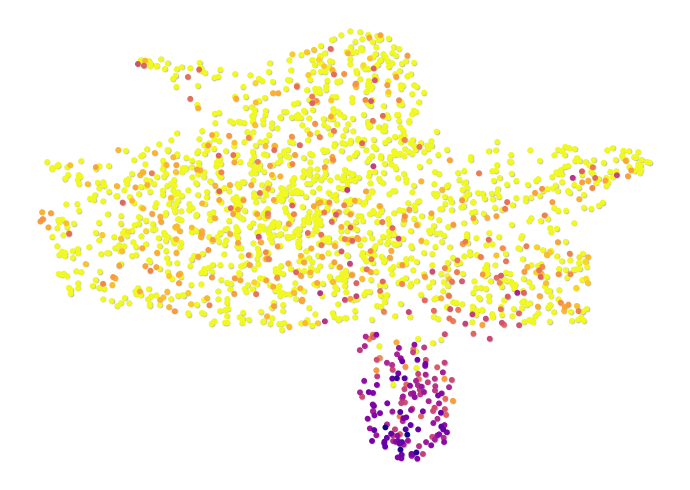

<Figure size 640x480 with 0 Axes>

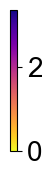

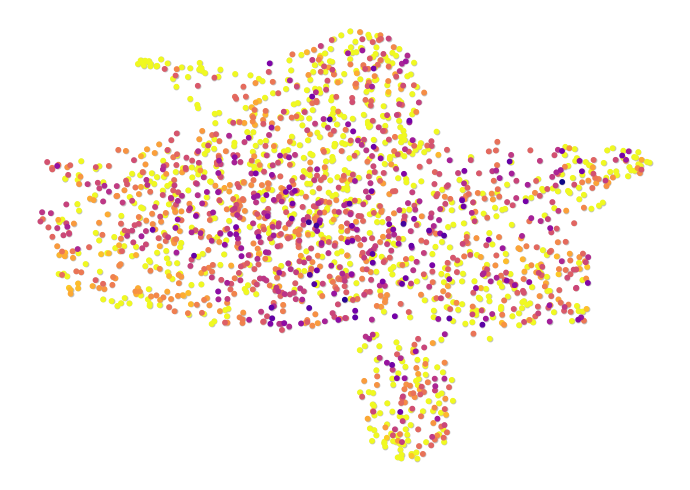

<Figure size 640x480 with 0 Axes>

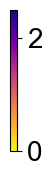

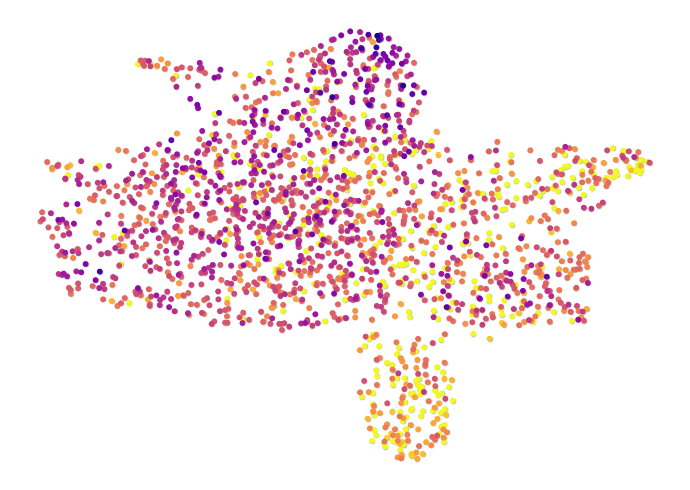

<Figure size 640x480 with 0 Axes>

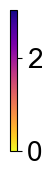

In [22]:
Genes_to_plot = ['HDC', 'PLEK', 'PCNA', 'RPL9']
for gene in Genes_to_plot:
    plot_genes(adata, gene, 'spliced', log_scale = True, basis='umap_ori', savefile = gene+'_spliced.png', expr_percentile = 100, s=10, shrink=0.3, labelsize=20, cbar_save=gene+'_spliced'+'_colorbar'+'.svg')

<font size="6">*HDC* is strongly associated with basophils</font>
<br>
<font size="6">*PLEK* is connected to megakaryocytes</font>
<br>
<font size="6">*PCNA*, *RPL9* are ubiquitously expressed and topics 5 and 6 are correlated with minichromosome (MCM-genes) and ribsome(RPL-genes) so we do not use topics 5 and 6 for downstream analysis.</font>

<font size="6">Now Let's see how *TopicVelo*'s use of topic modeling helps zoom into the dynamics of key genes</font>

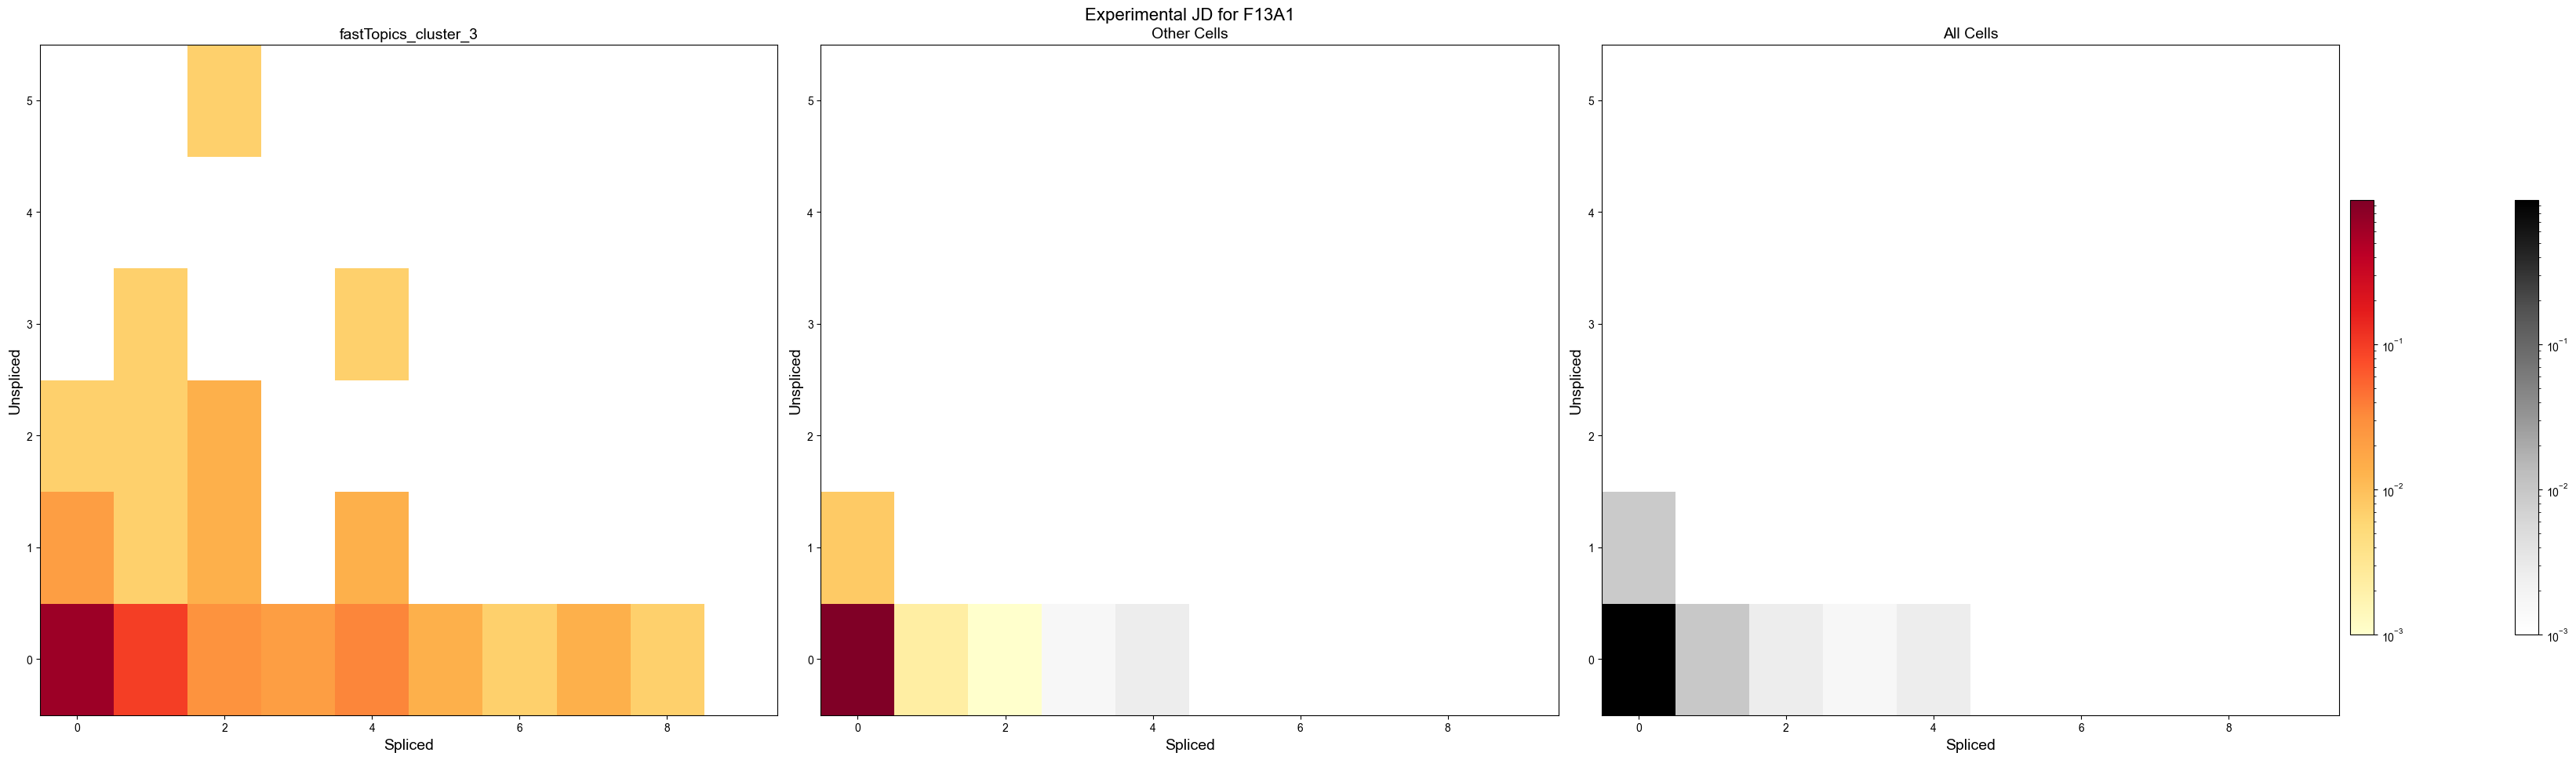

In [23]:
gene = 'F13A1'
topic_to_focus = '3'
heatmap_exper_cluster_focus_jd(adata, gene, clusters= 'fastTopics_cluster', focus = topic_to_focus, vmin=1e-3, x_cutoff=10)

<font size="6">We observed trend of upgregulations in the distribution over topics which is not seen in the distribution over all cells</font>

<font size="6">The following code demonstrates the joint distribution recovery process of F13A1 in topic 3 via one-state model vs. the burst model</font>

In [24]:
#create a subset of only cells whose highest topic weight is topic 3
ts = [3]
ttc_indices = []
for k in ts:
    ttc_indices.extend([i for i in range(adata.n_obs) if adata.obs['fastTopics_cluster'][i] == k])
adata_subset_3 = adata[ttc_indices]

<font size="6">For the one state model, we showed the maximum liklihood estimation parameters are $\alpha'=<u>$ and $\gamma' = \frac{<u>}{<s>}$. 
<br>
    For the burst model, we use our numerical inference scheme to estimate the MLE parameters.</font>

In [25]:
#analytical MLE for one state
alpha = np.mean(adata_subset_3[:,gene].layers['raw_unspliced'])
gamma = alpha/np.mean(adata_subset_3[:,gene].layers['raw_spliced'])

#numerical estimate MLE with the burst model 
InferredParameters, minKL = burst_inference_gene(adata_subset_3, gene, xkey = 'raw_spliced')

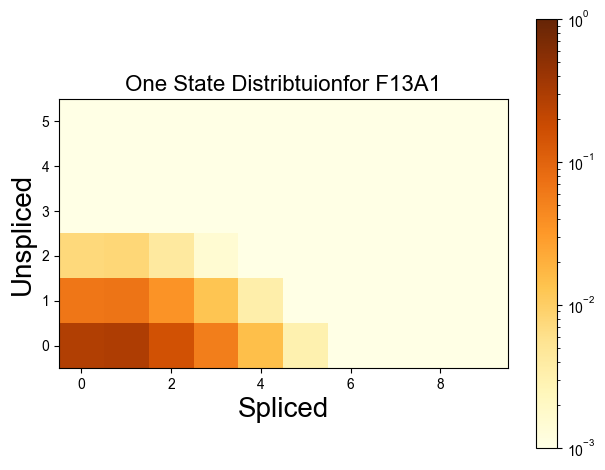

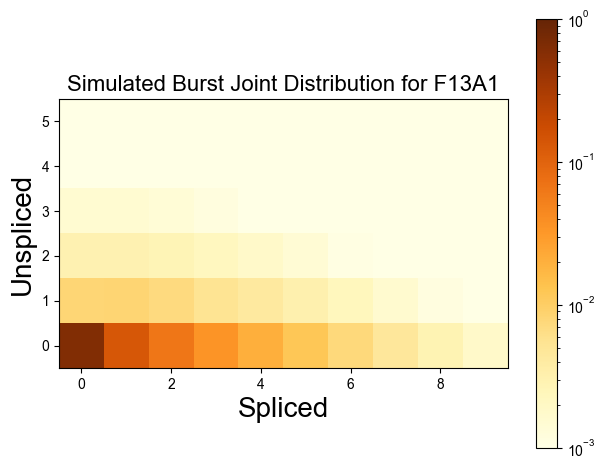

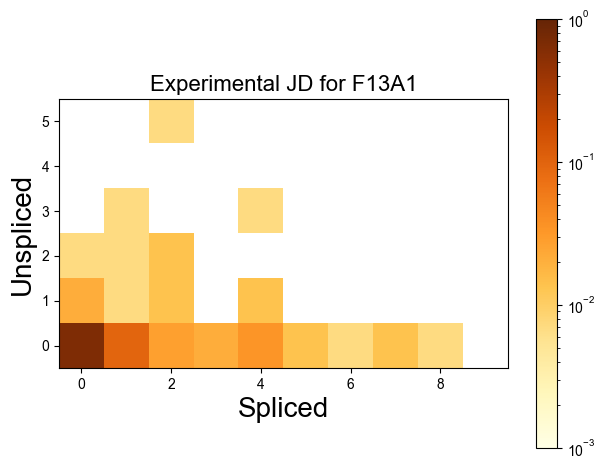

In [26]:
#Joint distribution for one-state
OS_JD = plot_os_analytical_jd(gene, (alpha, gamma), 6, 10, vmax = 1, vmin = 1e-3, log_scale_cb = True, save = 'F13A1_OS_topic3.svg')

#Joint distribution for burst model
Burst_sim_JD = plot_burst_sim_jd(gene, InferredParameters, x_cutoff = 10, y_cutoff = 6, vmax = 1, vmin = 1e-3, log_scale_cb = True, save = 'F13A1_burst_topic3.svg')

#plot the experimental distribution again
F13A1_t3_JD = plot_exper_jd(adata_subset_3, gene, xkey = 'raw_spliced', ukey='raw_unspliced', x_cutoff = 10, y_cutoff = 6, vmin=1e-3, vmax=1, log_scale_cb = True, save = 'F13A1_EXP_JD_Topic.svg')

In [27]:
#KL divergence between the one state model and observed
print(np.log(KL_divergence(OS_JD, F13A1_t3_JD)))

#KL divergence between the burst model and observed
print(np.log(KL_divergence(Burst_sim_JD, F13A1_t3_JD)))

-0.06538229616251896
-0.1315164195079842


<font size="6">We see the recovery using the burst model matches the experimental distribution more closely than the one-state model especially in the lowly expressed regime.</font>

<font size="10">Choosing topic threshold</font>
<br>
<font size="6">Let's use the heuristics based on the KL divergence of topic genes with the highest log-fold changes</font>

<font size="10">TopicVelo integrates the transition matrices</font>
<br>
<font size="6">We will use previously determined threshold on the topics relevant to differentitaion</font>

In [28]:
topics = [0,1,3,4,7]
topics_to_use_percentile_thresholds = [35, 35, 35, 35, 35]

In [29]:
combined_TM, ttc_indices = combined_topics_transitions(adata, topics = topics, velocity_type = 'burst', 
                                                            recompute = True, recompute_matrix = True, steady_state_perc = 95,
                                                            topic_weights_th_percentile = topics_to_use_percentile_thresholds, 
                                                            subset_save_prefix = 'scNT_HH_') 

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
The correlation threshold has been reduced to -0.8483.
Please be cautious when interpreting results.
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Time Taken:------------------->] 100 %
55.872905015945435
computing velocity graph (using 1/12 cores)


  0%|          | 0/1265 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'burst_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'burst_velocity_length' (adata.obs)
--> added 'burst_velocity_confidence' (adata.obs)
--> added 'burst_velocity_confidence_transition' (adata.obs)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Time Taken:------------------->] 100 %
29.323229789733887
computing velocity graph (using 1/12 cores)


  0%|          | 0/1265 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'burst_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'burst_velocity_length' (adata.obs)
--> added 'burst_velocity_confidence' (adata.obs)
--> added 'burst_velocity_confidence_transition' (adata.obs)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Time Taken:------------------->] 100 %
72.07694411277771
computing velocity graph (using 1/12 cores)


  0%|          | 0/1265 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'burst_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'burst_velocity_length' (adata.obs)
--> added 'burst_velocity_confidence' (adata.obs)
--> added 'burst_velocity_confidence_transition' (adata.obs)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Time Taken:------------------->] 100 %
46.05569314956665
computing velocity graph (using 1/12 cores)


  0%|          | 0/1265 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'burst_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'burst_velocity_length' (adata.obs)
--> added 'burst_velocity_confidence' (adata.obs)
--> added 'burst_velocity_confidence_transition' (adata.obs)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocities
The correlation threshold has been reduced to -0.2553.
Please be cautious when interpreting results.
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Time Taken:------------------->] 100 %
17.956835746765137
computing velocity graph (using 1/12 cores)


  0%|          | 0/1265 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'burst_velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'burst_velocity_length' (adata.obs)
--> added 'burst_velocity_confidence' (adata.obs)
--> added 'burst_velocity_confidence_transition' (adata.obs)
0
1
2
3
4


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap_ori', embedded velocity vectors (adata.obsm)


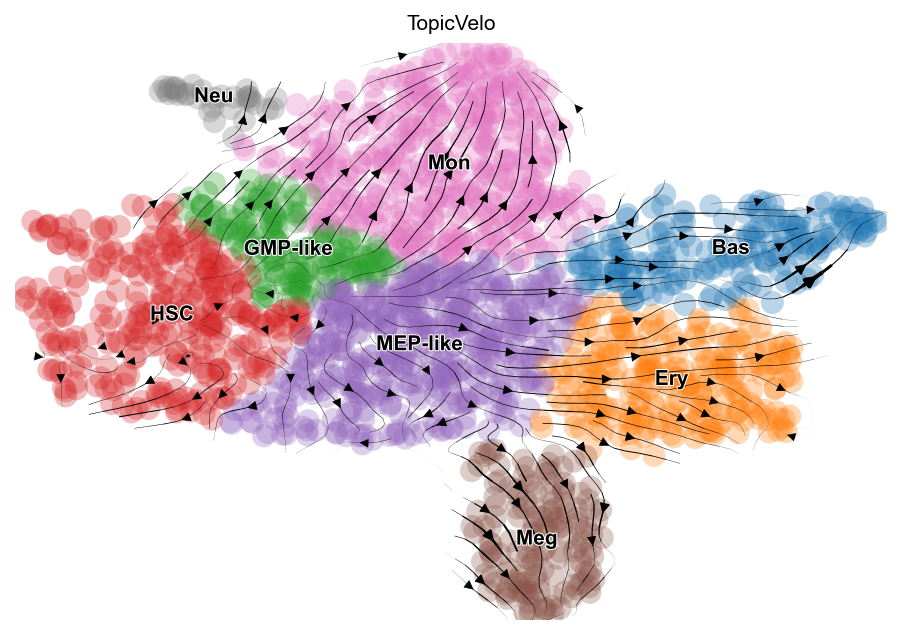

In [30]:
#compute embedded velocity vectors from TopicVelo's integrated transition matrix
topicVelo_embedding = scv.tl.velocity_embedding(adata, basis='umap_ori', T=combined_TM)
scv.pl.velocity_embedding_stream(adata, basis='umap_ori', V=topicVelo_embedding, dpi=150, color='cell_type', legend_loc='on data',
                                 title = 'TopicVelo', figsize=(7.5, 5))

<font size="6">The streamline from *TopicVelo*, as opposed to *scVelo* captures majority of differentiation lineages and agrees much better with *dynamo* (Please see main Figure 3 a, b, c for a side-by-side comparision.</font>

<font size="6">Compute Stationary distribution </font>

In [31]:
adata.obs['topicVelo_stationary_distribution'] = fate_probabilities(adata, 'topicVelo')

In [32]:
adata.obsp['scvelo_stochastic_T'] = get_transition_matrix(adata, vkey='scvelo_stochastic_velocity')
adata.obs['scvelo_stochastic_stationary_distribution'] = fate_probabilities(adata, 'scvelo_stochastic')

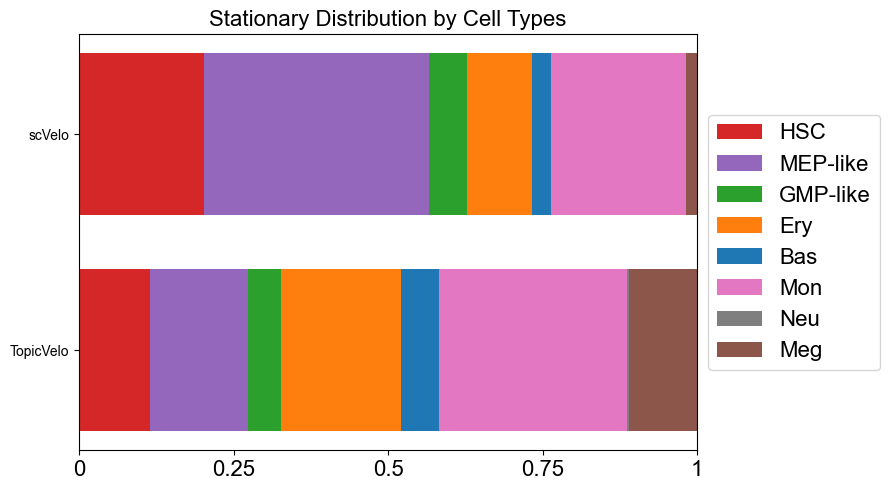

In [33]:
comparision_stacked_bar_plot(adata, ['scvelo_stochastic_stationary_distribution', 'topicVelo_stationary_distribution'], 
                             labels=['scVelo', 'TopicVelo'], groupby='cell_type',
                             categories=['HSC', 'MEP-like', 'GMP-like',  'Ery', 'Bas', 'Mon', 'Neu', 'Meg'],
                        fontsize=16,  title='Stationary Distribution by Cell Types',
                        figsize=(9,5), savefile='stat_dist.svg')

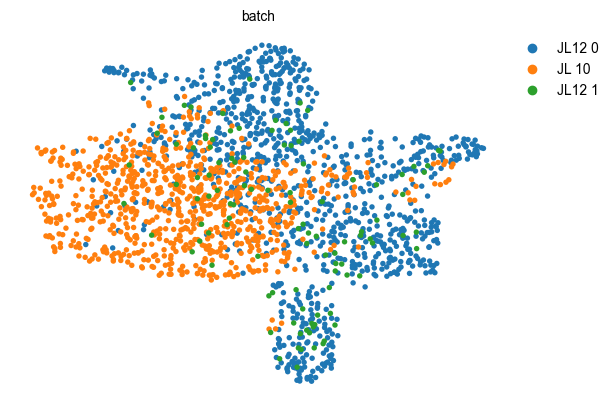

In [34]:
scv.pl.scatter(adata, basis='umap_ori', color='batch')

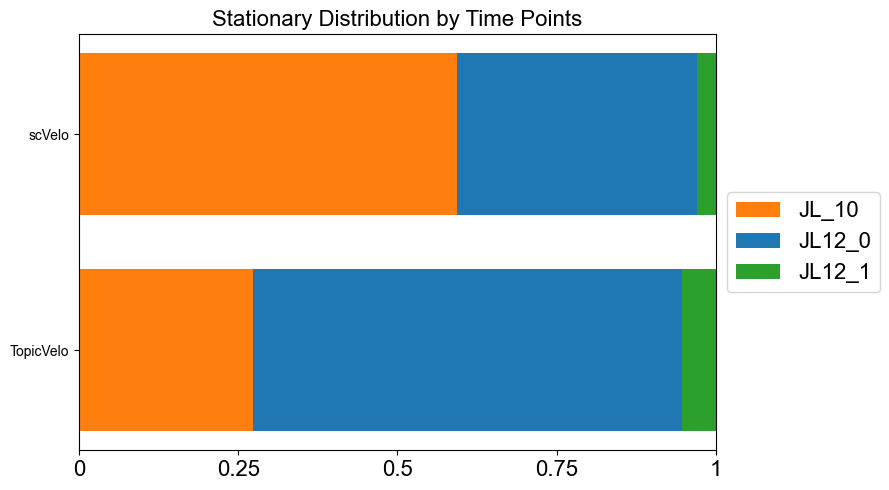

In [35]:
comparision_stacked_bar_plot(adata, ['scvelo_stochastic_stationary_distribution', 'topicVelo_stationary_distribution'], 
                             labels=['scVelo', 'TopicVelo'], groupby='batch',
                             categories=['JL_10', 'JL12_0', 'JL12_1'],
                        fontsize=16,  title='Stationary Distribution by Time Points',
                        figsize=(9,5), savefile='stat_dist_timepoint.svg')

<font size="6">Compute mean first passage time </font>

In [36]:
#choose destination cells for the mfpt analysis
#cells that have very high meg characteristics were chosen 
dest_cells, _ = get_cells_indices(adata, [3], topic_weights_th_percentile = 95)
dest_cells = np.unique(np.array(dest_cells).flatten())

In [37]:
mfpt_to_targets(adata, 'topicVelo', dest_cells, k_mfpt = 'topicVelo_mfpt_3')
mfpt_to_targets(adata, 'scvelo_stochastic', dest_cells, k_mfpt = 'scVelo_mfpt_3')

barcode
CCACAAGCGTGC-JL12_0    0.969066
CCATCCTGTGGA-JL12_0    0.000000
CCCTCGGCCGCA-JL12_0    0.992642
CCGCCCACCATG-JL12_0    0.969920
CCGCTGTGTAAG-JL12_0    0.961292
                         ...   
GTGAACCTGTGA-JL12_1    1.003056
GTGAGACAATAC-JL12_1    0.987428
GTGATATTGACC-JL12_1    0.669552
GTGCCGCGACAA-JL12_1    0.910084
GTGTGCATTCCT-JL12_1    0.960299
Name: scVelo_mfpt_3, Length: 1947, dtype: float64

In [38]:
#Put other cell types into their own things
aggregate_clusters(adata, 'cell_type', ['HSC', 'MEP-like', 'Ery', 'Meg'], 'cell_type_agg', other_names='others')

In [39]:
adata.obs['cell_type_agg']

barcode
CCACAAGCGTGC-JL12_0      others
CCATCCTGTGGA-JL12_0         Meg
CCCTCGGCCGCA-JL12_0      others
CCGCCCACCATG-JL12_0      others
CCGCTGTGTAAG-JL12_0    MEP-like
                         ...   
GTGAACCTGTGA-JL12_1    MEP-like
GTGAGACAATAC-JL12_1    MEP-like
GTGATATTGACC-JL12_1    MEP-like
GTGCCGCGACAA-JL12_1      others
GTGTGCATTCCT-JL12_1         Ery
Name: cell_type_agg, Length: 1947, dtype: object

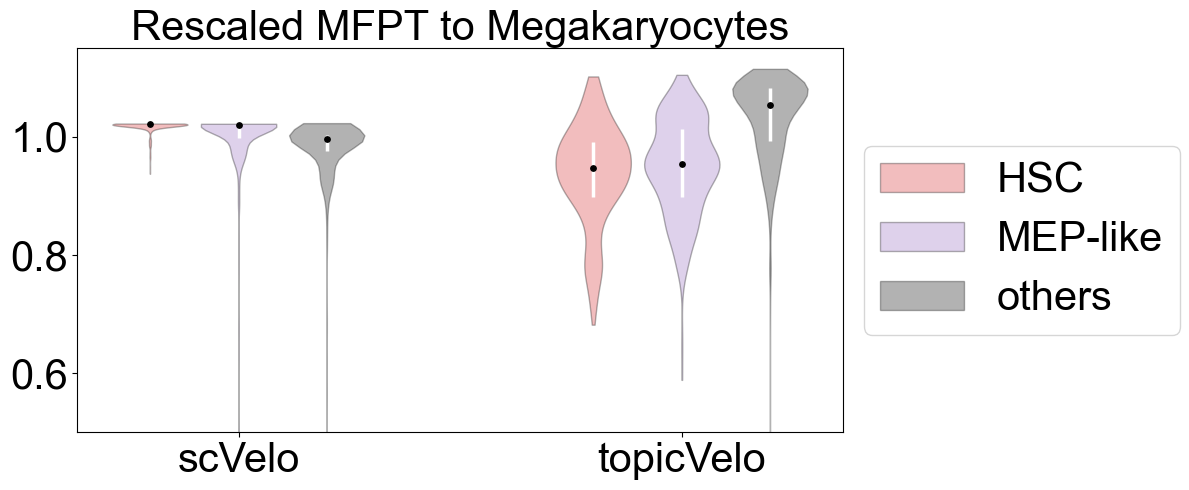

In [40]:
comparision_violin_plot_v2(adata, ['scVelo_mfpt_3', 'topicVelo_mfpt_3'], ['HSC','MEP-like', 'others'],
                           groupby='cell_type_agg', xlabels=['scVelo','topicVelo'],
                           groupby_spacing=5, title='Rescaled MFPT to Megakaryocytes',fontsize=30,
                           figsize=(12,5), ylim=[0.5,1.15], savefile='mfpt_3_main.svg')

<font size="6">Permutation test to get statistical significance between the distribution of mfpt</font>

In [41]:
for k_mfpt in ['scVelo_mfpt_3', 'topicVelo_mfpt_3']:
    print(k_mfpt, 'HSC', permutation_test(adata, 'cell_type_agg', 'HSC', 'others', k_mfpt, alternative='less'))

scVelo_mfpt_3 HSC 1.0
topicVelo_mfpt_3 HSC 0.0001


In [42]:
for k_mfpt in ['scVelo_mfpt_3', 'topicVelo_mfpt_3']:
    print(k_mfpt, 'MEP-like', permutation_test(adata, 'cell_type_agg', 'MEP-like', 'others', k_mfpt, alternative='less'))

scVelo_mfpt_3 MEP-like 1.0
topicVelo_mfpt_3 MEP-like 0.0001


<font size="6">Compute relative flux between known transitions </font>

In [43]:
cluster_transitions = [('GMP-like','Mon'),('GMP-like','Bas'),
                       ('MEP-like','Ery'), ('MEP-like','Meg')]
transition_matrices = [ 'scvelo_stochastic_T', 'topicVelo_T']

In [44]:
res = []
for k_transition_matrix in transition_matrices:
    res.append((k_transition_matrix, 
                relative_flux_correctness(adata,'cell_type', k_transition_matrix, cluster_transitions)[0]))

In [45]:
res

[('scvelo_stochastic_T',
  {('GMP-like', 'Mon'): 0.02974682575973119,
   ('GMP-like', 'Bas'): -0.15163620364637181,
   ('MEP-like', 'Ery'): 0.357537601683129,
   ('MEP-like', 'Meg'): 0.0077515491028809546}),
 ('topicVelo_T',
  {('GMP-like', 'Mon'): 0.22981698002484888,
   ('GMP-like', 'Bas'): -0.15518153034427268,
   ('MEP-like', 'Ery'): 0.4674844989485553,
   ('MEP-like', 'Meg'): 0.4615798995295082})]

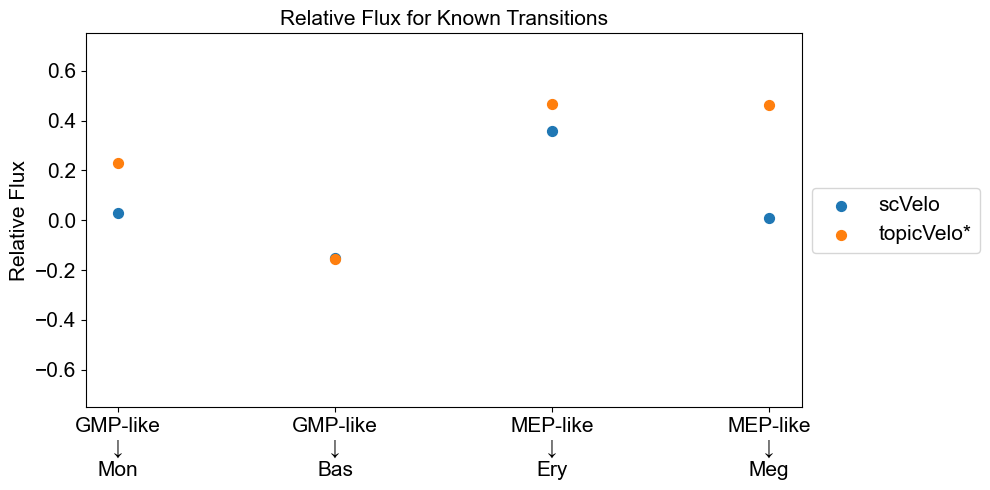

In [46]:
relative_flux_plot(adata,['scvelo_stochastic_T','topicVelo_T'], 
                   legends = ['scVelo', 'topicVelo*'],
                   title = 'Relative Flux for Known Transitions', ylim=[-0.75, 0.75], figsize=(10,5), fontsize=15)